In [3]:
# Author: Yichun Zhao

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


-----------------------DATA PROCESSING-----------------------



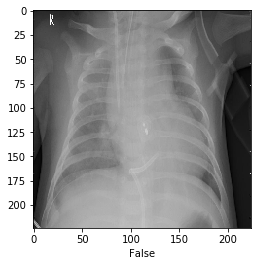

[[ 17  30  37 ...  51  84  94]
 [ 26  33  38 ...  48  73  77]
 [ 30  39  40 ...  52  51  69]
 ...
 [ 33  29 128 ...  24  23  23]
 [ 34  38  30 ...  24  24  24]
 [ 36  39  36 ...  24  25  25]]


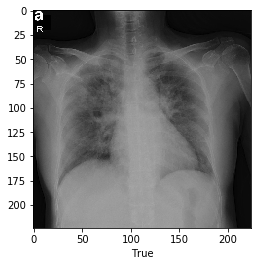

[[ 12  13  12 ...  12  12  13]
 [ 13  13  14 ...  13  12  12]
 [ 12  12 119 ...  13  12  12]
 ...
 [ 10  11  10 ...  11  11  11]
 [ 10  10  10 ...  10  11  11]
 [ 11  10  10 ...  11  11  11]]


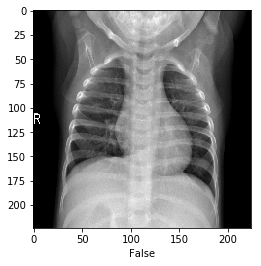

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
# importing data
print("\n-----------------------DATA PROCESSING-----------------------\n")
import os
import imutils
import cv2

images = []
labels = []

yes_path = os.path.abspath('')+"/dataset/train_test/yes/"
for file in os.listdir(yes_path):
    image = cv2.imread(yes_path+file, cv2.IMREAD_GRAYSCALE)
    # resize images to same size
    image = cv2.resize(image, (224, 224))
    images.append(image)
    labels.append(True)
    
no_path = os.path.abspath('')+"/dataset/train_test/no/"
for file in os.listdir(no_path):
    image = cv2.imread(no_path+file, cv2.IMREAD_GRAYSCALE)
    # resize images to same size
    image = cv2.resize(image, (224, 224))
    images.append(image)
    labels.append(False)

# visualize input images
import random
for i in random.sample(range(0, 50), 3):
    plt.imshow(images[i], cmap='gray')
    plt.xlabel(labels[i])
    plt.show()
    print(images[i])

# normalize and reshape into appropriate dimensions
images = np.array(images)/255
images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1) #TF needs 4D shaped data
labels = np.array(labels) * 1
labels = labels.reshape(labels.shape[0], -1) #2D output data

In [11]:
# k fold cross validation
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, shuffle=True)

# build neural net
print("\n-----------------------BUILDING NEURAL NET-----------------------\n")

model = keras.models.Sequential()
# conv layer
model.add(keras.layers.Conv2D(9, (5, 5), activation='relu', padding='same'))
# max pool
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same'))
model.add(keras.layers.Flatten())
# hidden layer
model.add(keras.layers.Dense(256, activation='relu'))
# output layer for binary output
model.add(keras.layers.Dense(1, activation='sigmoid'))
    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\n-----------------------TRAINING MODEL-----------------------\n")

fold_num = 1
for train, test in kf.split(images, labels):
    print("Training for fold ", fold_num, "...\n")
    #within each fold, we train and test our network
    
    model.fit(images[train], labels[train], epochs=5, batch_size=8)
    
    test_loss, test_acc = model.evaluate(images[test], labels[test])
    
    print("Accuracy from testing: ", test_acc, "\n")
    
    fold_num = fold_num+1



-----------------------BUILDING NEURAL NET-----------------------


-----------------------TRAINING MODEL-----------------------

Training for fold  1 ...

Epoch 1/5
5/5 [==============================] - 2s 381ms/step - loss: 6.7326 - accuracy: 0.6000
Epoch 2/5
5/5 [==============================] - 2s 404ms/step - loss: 0.5751 - accuracy: 0.8000
Epoch 3/5
5/5 [==============================] - 2s 377ms/step - loss: 0.3886 - accuracy: 0.8250
Epoch 4/5
5/5 [==============================] - 2s 388ms/step - loss: 0.0558 - accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 999us/step - loss: 0.3186 - accuracy: 0.8000
Accuracy from testing:  0.800000011920929 

Training for fold  2 ...

Epoch 1/5
5/5 [==============================] - 2s 413ms/step - loss: 0.0969 - accuracy: 0.9250
Epoch 2/5
5/5 [==============================] - 2s 456ms/step - loss: 0.0387 - accuracy: 0.9750
Epoch 3/5
5/5 [==============================] - 2s 387ms/step - loss: 0.0203 - accuracy: 1.00

In [12]:
print("\n-----------------------SUMMARY-----------------------\n")
model.summary()


-----------------------SUMMARY-----------------------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 9)       234       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 9)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 16)      3616      
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               51380480  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 51,384,587
Trainable params: 51,384,587
Non-traina

In [13]:
# save keras model
model.save(os.path.abspath('')+"/model")

# save to tfjs model for web app
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, os.path.abspath('')+"/webapp/tfjs_model")

INFO:tensorflow:Assets written to: C:\Users\Yichun\Documents\UVic\2020 Fall\HINF 491\prototype\model_training/model\assets
